In [1]:
%autoreload 2

In [28]:
import os
import pickle
import re
import sys
import typing

import torch.nn.functional as F

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch import Tensor
import transformers
from transformers import AutoTokenizer, AutoModel
import tqdm

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.ast_utils import load_games_from_file, _extract_game_id
game_texts = list(load_games_from_file('../dsl/interactive-beta.pddl'))


In [3]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


DEFAULT_DEVICE = device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16


def tokenize_and_embed(model: transformers.PreTrainedModel, tokenizer: typing.Union[transformers.PreTrainedTokenizer, transformers.PreTrainedTokenizerFast], 
    texts: typing.List[str], device: str = DEFAULT_DEVICE, batch_size: int = BATCH_SIZE) -> torch.Tensor:
    texts = ['query: ' + re.sub(r'\s+', ' ', text) for text in texts]

    all_embeddings = []

    for b in range(len(texts) // batch_size + 1):
        batch_texts = texts[b * batch_size: (b + 1) * batch_size]
        if len(batch_texts) == 0:
            continue

        # TODO: consider what to do about sequences longer than 512
        batch_dict = tokenizer(batch_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}
        outputs = model(**batch_dict)
        embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask']).detach().cpu()
        del batch_dict
        del outputs
        all_embeddings.append(embeddings)

    embeddings = torch.cat(all_embeddings, dim=0)
    return embeddings


In [4]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-large')
model = AutoModel.from_pretrained('intfloat/e5-large').to(DEFAULT_DEVICE)

In [13]:
REGENERATE_EMBEDDINGS = False 

if REGENERATE_EMBEDDINGS:
    embeddings = tokenize_and_embed(model, tokenizer, game_texts)
    print(embeddings.shape)
    torch.save(embeddings, '../data/interactive-beta-e5-embeddings.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)

else:
    embeddings = torch.load('../data/interactive-beta-e5-embeddings.pt')
    print(embeddings.shape)

torch.Size([98, 1024])


In [10]:
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
REGROWN_GAMES_PER_ORIGINAL = int(len(regrown_game_texts) / len(game_texts))
embeddings_by_original_game = []

In [14]:
REGENERATE_REGROWTH_EMBEDDINGS = False

if REGENERATE_REGROWTH_EMBEDDINGS:
    start_index = len(embeddings_by_original_game)

    for i in tqdm.notebook.trange(len(game_texts)):
        game_regrown_games = regrown_game_texts[i * REGROWN_GAMES_PER_ORIGINAL: (i + 1) * REGROWN_GAMES_PER_ORIGINAL]
        game_embeddings = tokenize_and_embed(model, tokenizer, game_regrown_games)
        embeddings_by_original_game.append(game_embeddings)

    regrown_embeddings = torch.stack(embeddings_by_original_game)
    print(regrown_embeddings.shape)
    torch.save(regrown_embeddings, '../data/ast-real-regrowth-samples-e5-embeddings.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)

else:
    regrowth_embeddings = torch.load('../data/ast-real-regrowth-samples-e5-embeddings.pt')
    print(regrowth_embeddings.shape)

torch.Size([98, 64, 1024])


In [15]:
all_embeddings = torch.cat([embeddings, regrowth_embeddings.reshape(-1, regrowth_embeddings.shape[-1])], dim=0)
all_embeddings.shape

torch.Size([6370, 1024])

In [18]:
pca = PCA(n_components=100)
pca.fit(all_embeddings.numpy())

PCA(n_components=100)

0.047624927

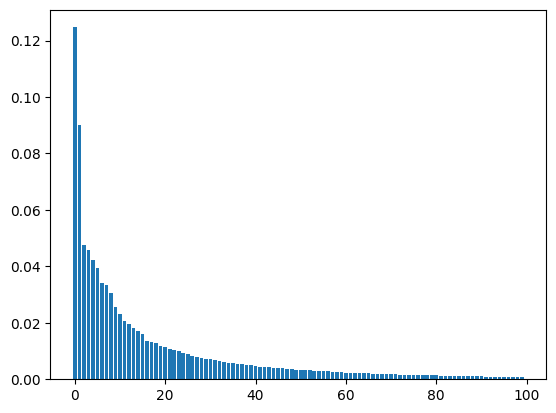

In [21]:
n_components = 100
plt.bar(np.arange(n_components), pca.explained_variance_ratio_[:n_components])
pca.explained_variance_ratio_[64:].sum()

In [22]:
PCA_N_DIM = 64
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', random_state=SEED)

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None):

    if pca_kwargs is None:
        pca_kwargs = PCA_KWARGS
    else:
        temp_kwargs = PCA_KWARGS.copy()
        temp_kwrags.update(pca_kwargs)
        pca_kwargs = temp_kwargs

    if tsne_kwargs is None:
        tsne_kwargs = TSNE_KAWRGS

    else:
        temp_kwrags = TSNE_KAWRGS.copy()
        temp_kwrags.update(tsne_kwargs)
        tsne_kwargs = temp_kwrags

    if data.ndim > 2:
        data = data.reshape(-1, data.shape[-1])

    pca = PCA(n_components=pca_n_dim, **pca_kwargs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data_pca)

    return data_tsne

tsne_embedded_data = pca_and_tsne(all_embeddings.numpy())
tsne_embedded_data.shape

(6370, 2)

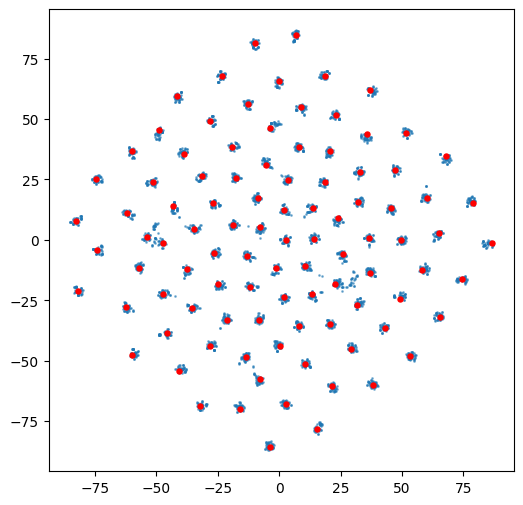

In [23]:
n_games = len(game_texts)
plt.figure(figsize=(6, 6))
plt.scatter(tsne_embedded_data[n_games:, 0], tsne_embedded_data[n_games:, 1], s=1, alpha=0.5)
plt.scatter(tsne_embedded_data[:n_games, 0], tsne_embedded_data[:n_games, 1], s=13, c='red')


In [26]:
def cross_validate(embeddings_tensor: torch.Tensor,
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]],
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None, 
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    if cv_kwargs is None:
        cv_kwargs = {}

    if 'n_jobs' not in cv_kwargs: 
        cv_kwargs['n_jobs'] = -1
    if 'verbose' not in cv_kwargs:
        cv_kwargs['verbose'] = verbose

    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(model_kwargs=model_kwargs, train_kwargs=train_kwargs))])

    if isinstance(param_grid, list):
        for param_grid_dict in param_grid:
            param_grid_dict['fitness__n_features'] = [embeddings_tensor.shape[-1]]
    else:
        param_grid['fitness__n_features'] = [embeddings_tensor.shape[-1]]        

    random_seed = train_kwargs['random_seed'] if 'random_seed' in train_kwargs else None

    cv = GridSearchCV(pipeline, param_grid, scoring=scoring_function, 
        cv=KFold(n_folds, shuffle=True, random_state=random_seed), 
        **cv_kwargs)
    return cv.fit(embeddings_tensor, None)


def model_fitting_experiment(embeddings_tensor: torch.Tensor,
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]], 
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0
    ):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    cv = cross_validate(embeddings_tensor, param_grid,
        scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, 
        model_kwargs=model_kwargs, cv_kwargs=cv_kwargs, n_folds=n_folds, verbose=verbose)
    # best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore

    # TODO: add evaluation on the held-out part of the dataset here
    return cv



In [27]:
embeddings_for_fitness = torch.cat([embeddings.unsqueeze(1), regrowth_embeddings], dim=1)
embeddings_for_fitness.shape

torch.Size([98, 65, 1024])

In [30]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv = model_fitting_experiment(embeddings_for_fitness, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable T

In [31]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_df.sort_values(by='ecdf_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
649,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,4,1024,0.25,-0.295601,0.022673,1,0.960304,0.004551,8
21,2,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,2,1024,0.25,-0.296159,0.021126,2,0.955008,0.008715,66
977,16,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,1,1024,0.25,-0.296527,0.015451,3,0.960164,0.011788,12
677,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.01,2,1024,0.25,-0.296528,0.029063,4,0.959367,0.006567,17
652,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,8,1024,0.00,-0.297726,0.020346,5,0.963331,0.006281,3
645,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,2,1024,0.25,-0.297776,0.029778,6,0.963980,0.009642,1
36,2,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.01,2,1024,0.00,-0.298391,0.025859,7,0.956513,0.009495,46
661,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,2,1024,0.25,-0.298881,0.014159,8,0.962944,0.006605,4
676,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.01,2,1024,0.00,-0.299467,0.029532,9,0.956990,0.009938,41
983,16,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,2,1024,2.00,-0.300058,0.028551,10,0.953734,0.008089,91


In [32]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
645,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,2,1024,0.25,-0.297776,0.029778,6,0.963980,0.009642,1
12,2,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,8,1024,0.00,-0.314023,0.019388,155,0.963577,0.009478,2
652,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,8,1024,0.00,-0.297726,0.020346,5,0.963331,0.006281,3
661,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,2,1024,0.25,-0.298881,0.014159,8,0.962944,0.006605,4
24,2,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,4,1024,0.00,-0.305198,0.024615,31,0.961809,0.009864,5
964,16,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,2,1024,0.00,-0.307019,0.027721,41,0.961669,0.007382,6
965,16,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,2,1024,0.25,-0.304885,0.012716,29,0.960403,0.009129,7
649,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,4,1024,0.25,-0.295601,0.022673,1,0.960304,0.004551,8
648,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.10,4,1024,0.00,-0.302457,0.026900,20,0.960280,0.009799,9
664,8,4,<function fitness_hinge_loss at 0x7f05b514bb50>,0.03,4,1024,0.00,-0.300818,0.027830,12,0.960271,0.012376,10


In [33]:
cv.best_estimator_.fit(embeddings_for_fitness)
cv_fitness_model = cv.best_estimator_

In [34]:
real_scores = cv_fitness_model.transform(embeddings_for_fitness[:, 0, :]).detach().squeeze().numpy()
negative_scores = cv_fitness_model.transform(embeddings_for_fitness[:, 1:, :]).detach().squeeze().numpy()
real_scores.mean(), real_scores.std()

(-4.772601, 6.032575)

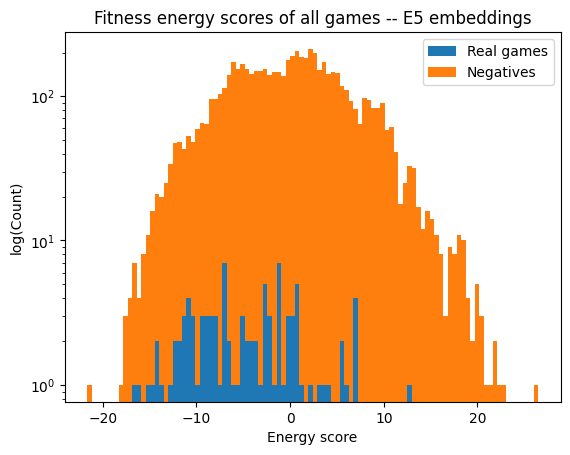

In [35]:
plt.hist([real_scores, negative_scores.flatten()], stacked=True, bins=100,
    label=['Real games', 'Negatives'])
plt.title('Fitness energy scores of all games -- E5 embeddings')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')